# WHFast tutorial

This tutorial is an introduction to the python interface of WHFast, a fast and unbiased symplectic Wisdom-Holman integrator. The method is described in Rein & Tamayo (2015).

This tutorial assumes that you have already installed REBOUND.

## First WHFast integration
You can enter all the commands below into a file and execute it all at once, or open an interactive shell).

First, we need to import the REBOUND module (make sure have have enabled the virtual environment if you used it to install REBOUND).

In [1]:
import rebound

Next, let's add some particles. We'll work in units in which $G=1$ (see below on how to set $G$ to another value). The first particle we add is the central object. We place it at rest at the origin and use the convention of setting the mass of the central object $M_*$ to 1:

In [2]:
rebound.add(m=1.)

Let's look at the particle we just added:

In [4]:
print(rebound.particles[0])

<rebound.Particle object, m=1.0 x=0.0 y=0.0 z=0.0 vx=0.0 vy=0.0 vz=0.0>


The output tells us that the mass of the particle is 1 and all coordinates are zero. 

The next particle we're adding is a planet. We'll use Cartesian coordinates to initialize it. Any coordinate that we do not specify in the `rebound.add()` command is assumed to be 0. We place our planet on a circular orbit at $a=1$ and give it a mass of $10^{-3}$ times that of the central star.

In [5]:
rebound.add(m=1e-3, x=1., vy=1.)

Instead of initializing the particle with Cartesian coordinates, we can also use orbital elements. By default, REBOUND will use Jacobi coordinates, i.e. REBOUND assumes the orbital elements describe the particle's orbit around the centre of mass of all particles added previously. Our second planet will have a mass of $10^{-3}$, a semimajoraxis of $a=2$ and an eccentricity of $e=0.1$:

In [6]:
rebound.add(m=1e-3, a=2., e=0.1)

Now that we have added two more particles, let's have a quick look at what's "in REBOUND" by using

In [7]:
rebound.status()

---------------------------------
Rebound version:     	1.0.0
Build on:            	b'Jun 11 2015 13:31:04'
Number of particles: 	3
Simulation time:     	0.000000
---------------------------------
<rebound.Particle object, m=1.0 x=0.0 y=0.0 z=0.0 vx=0.0 vy=0.0 vz=0.0>
<rebound.Particle object, m=0.001 x=1.0 y=0.0 z=0.0 vx=0.0 vy=1.0 vz=0.0>
<rebound.Particle object, m=0.001 x=1.800999000999001 y=0.0 z=0.0 vx=0.0 vy=0.7835163064519431 vz=0.0>
---------------------------------


Next, let's tell REBOUND which integrator (WHFast, of course!) and timestep we want to use. In our system of units, an orbit at $a=1$ has the orbital period of $T_{\rm orb} =2\pi \sqrt{\frac{GM}{a}}= 2\pi$. 
So a reasonable timestep to start with would be $dt=10^{-3}$.

In [8]:
rebound.integrator = "whfast"
rebound.dt = 1e-3 

`whfast` referrs to the 2nd order symplectic integrator WHFast described by Rein & Tamayo (2015). By default 11th order symplectic correctors are used. 

We are now ready to start the integration. Let's integrate for one orbit, i.e. until $t=2\pi$. Because we use a fixed timestep, rebound would have to change it to integrate exactly up to $2\pi$. Changing a timestep in a symplectic integrator is a bad idea, so we'll tell rebound to don't worry about the `exact_finish_time`.

In [9]:
rebound.integrate(6.28318530717959, exact_finish_time=0)   # 6.28318530717959 is 2*pi

Once again, let's look at what REBOUND's status is

In [10]:
rebound.status()

---------------------------------
Rebound version:     	1.0.0
Build on:            	b'Jun 11 2015 13:31:04'
Number of particles: 	3
Simulation time:     	6.284000
---------------------------------
<rebound.Particle object, m=1.0 x=0.0033261548667885307 y=0.009674635913443521 z=0.0 vx=0.0005194654198158002 vy=0.0012200269279829012 vz=0.0>
<rebound.Particle object, m=0.001 x=1.0032694181735875 y=0.03662894131164787 z=0.0 vx=-0.0243959426078963 vy=0.9999782072259012 vz=0.0>
<rebound.Particle object, m=0.001 x=-1.5284252839639252 y=1.4963516149806093 z=0.0 vx=-0.4950694772080716 vy=-0.43648882875756767 vz=0.0>
---------------------------------


As you can see the time has advanced to $t=2\pi$ and the positions and velocities of *all* particles have changed. If you want to post-process the particle data, you can access it in the following way:

In [11]:
particles = rebound.particles
for p in particles:
    print(p.x, p.y, p.vx, p.vy)

0.0033261548667885307 0.009674635913443521 0.0005194654198158002 0.0012200269279829012
1.0032694181735875 0.03662894131164787 -0.0243959426078963 0.9999782072259012
-1.5284252839639252 1.4963516149806093 -0.4950694772080716 -0.43648882875756767


The `particles` object is an array of pointers to the particles. This means you can call `particles = rebound.particles` before the integration and the contents of `particles` will be updated after the integration. If you add or remove particles, you'll need to call `rebound.particles` again.

## Visualization with matplotlib
Instead of just printing boring numbers at the end of the simulation, let's visualize the orbit using matplotlib (you'll need to install numpy and matplotlib to run this example, see above).

We'll use the same particles as above. As the particles are already in memory, we don't need to add them again. Let us plot the position of the inner planet at 100 steps during its orbit. First, we'll import numpy and create an array of times for which we want to have an output (here, from $T_{\rm orb}$ to $2 T_{\rm orb}$ (we have already advanced the simulation time to $t=2\pi$).

In [12]:
import numpy as np
torb = 2.*np.pi
Noutputs = 100
times = np.linspace(torb, 2.*torb, Noutputs)
x = np.zeros(Noutputs)
y = np.zeros(Noutputs)

Next, we'll step through the simulation. Rebound will integrate up to `time`. Depending on the timestep, it might overshoot slightly. If you want to have the outputs at exactly the time you specify you can set the `exactTime=1` flag in the `integrate` function. However, note that changing the timestep in a symplectic integrator could have negative impacts on its properties.

In [13]:
for i,time in enumerate(times):
    rebound.integrate(time, exact_finish_time=0)
    x[i] = particles[1].x
    y[i] = particles[1].y

Let's plot the orbit using matplotlib.

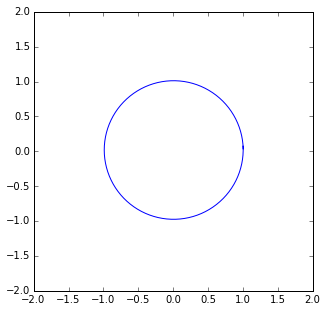

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5,5))
ax = plt.subplot(111)
ax.set_xlim([-2,2])
ax.set_ylim([-2,2])
plt.plot(x, y);

Hurray! It worked. The orbit looks like it should, it's an almost perfect circle. There are small perturbations though, induced by the outer planet. Let's integrate a bit longer to see them. 

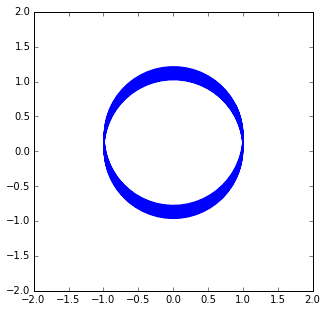

In [15]:
Noutputs = 1000
times = np.linspace(2.*torb, 20.*torb, Noutputs)
x = np.zeros(Noutputs)
y = np.zeros(Noutputs)
for i,time in enumerate(times):
    rebound.integrate(time, exact_finish_time=0)
    x[i] = particles[1].x
    y[i] = particles[1].y
    
fig = plt.figure(figsize=(5,5))
ax = plt.subplot(111)
ax.set_xlim([-2,2])
ax.set_ylim([-2,2])
plt.plot(x, y);

Oops! This doesn't look like what we expected to see (small perturbations to an almost circluar orbit). What you see here is the barycenter slowly drifting. Some integration packages require that the simulation be carried out in a particular frame, but WHFast provides extra flexibility by working in any inertial frame.  If you recall how we added the particles, the Sun was at the origin and at rest, and then we added the planets.  This means that the center of mass, or barycenter, will have a small velocity, which results in the observed drift.  There are multiple ways we can get the plot we want to.
1. We can calculate only relative positions.
2. We can add the particles in the barycentric frame.
3. We can let REBOUND transform the particle coordinates to the bayrcentric frame for us.

Let's use the third option (next time you run a simulation, you probably want to do that at the beginning).

In [16]:
rebound.move_to_com()

So let's try this again. Let's integrate for a bit longer this time.

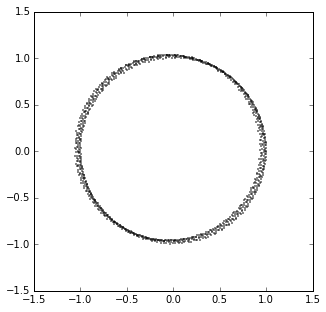

In [17]:
times = np.linspace(20.*torb, 1000.*torb, Noutputs)
for i,time in enumerate(times):
    rebound.integrate(time, exact_finish_time=0)
    x[i] = particles[1].x
    y[i] = particles[1].y
    
fig = plt.figure(figsize=(5,5))
ax = plt.subplot(111)
ax.set_xlim([-1.5,1.5])
ax.set_ylim([-1.5,1.5])
plt.scatter(x, y, marker='.', color='k', s=1.2);

That looks much more  like it. Let us finally plot the orbital elements as a function of time.

In [18]:
times = np.linspace(1000.*torb, 9000.*torb, Noutputs)
a = np.zeros(Noutputs)
e = np.zeros(Noutputs)
for i,time in enumerate(times):
    rebound.integrate(time, exact_finish_time=0)
    orbits = rebound.calculate_orbits()
    a[i] = orbits[1].a
    e[i] = orbits[1].e
    
fig = plt.figure(figsize=(15,5))

ax = plt.subplot(121)
ax.set_xlabel("time")
ax.set_ylabel("semi-major axis")
plt.plot(times, a);

ax = plt.subplot(122)
ax.set_xlabel("time")
ax.set_ylabel("eccentricity")
plt.plot(times, e);

KeyboardInterrupt: 

The semimajor axis seems to almost stay constant, whereas the eccentricity undergoes an oscillation. Thus, one might conclude the planets interact only secularly, i.e. there are no large resonant terms.

## Advanced settings of WHFast

You can set various attributes to change the default behaviour of WHFast depending on the problem you're interested in.

### Symplectic correctors
You can change the  order of the symplectic correctors in WHFast. The default is 11. If you simply want to turn off symplectic correctors alltogether, you can just choose the `whfast-nocor` integrator:

In [ ]:
rebound.integrator = "whfast-nocor"

You can also set the order of the symplectic corrector explicitly:

In [ ]:
rebound.integrator = "whfast"
rebound.integrator_whfast_corrector = 7

You can choose between 0 (no correctors), 3, 5, 7 and 11 (default).

### Keeping particle data synchronized
By default, REBOUND will only synchronized particle data at the end of the integration, i.e. if you call `rebound.integrate(100.)`, it will assume you don't need to access the particle data between now and $t=100$. There are a few instances where you might want to change that. 

One example is MEGNO. Whenever you calculate MEGNO or the Lyapunov exponent, REBOUND needs to have the velocities and positions synchronized at the end of the timestep (to calculate the dot product between them). Thus, if you initialize MEGNO with 

In [ ]:
rebound.init_megno(1e-16)

you implicitly force REBOUND to keep the particle coordinates synchronized. This will slow it down and might reduce its accuracy. You can also manually force REBOUND to keep the particles synchronized at the end of every timestep by integrating with the `synchronize_each_timestep` flag set to 1:

In [ ]:
rebound.integrate(10., synchronize_each_timestep=1)

In either case, you can change particle data between subsequent calls to integrate:

In [ ]:
rebound.integrate(20.)
rebound.particles[0].m = 1.1 # Sudden increase of particle's mass
rebound.integrate(30.)